# Proper Orthogonal Decomposition (POD):

This is an algorithm of the type Reduce Order Models (ROMs). The following examples are from the lectures by Nathan Kutz:

https://www.youtube.com/watch?v=YX24Jgd90uY

https://www.youtube.com/watch?v=X5GhhjpX0ao

https://www.youtube.com/watch?v=sK0cUVD7mxw

# Example 1: Harmonic Oscillator (Schrodinger's equation with parabolic potential)
$$
  u_t = \frac{i}{2}u_{xx} -i \frac{x^2}{2}u
$$
$$
u(x,0) = u_0(x) = \exp(-\sigma(x-x_0)^2)
$$

$u_0$ is a Gaussian pulse with variance $\sigma$ and centered at $x0$


In [131]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import scipy
from scipy import *
import scipy.integrate

In [132]:
L = 30
n = 512  # n points in the x coordinate
x2 = np.linspace(-L/2, L/2, n+1)  # to generate grid points, assumes first and last are the same..
x = x2[0:n] # grid points
V = x**2 # potential
t = np.linspace(0, 20, 101) 

### compute the wave numbers since we solve by transforming Fourier the PDE to convert it into an ODE



In [133]:
# column vector [0,...255,-256,-255,...,-1]
k = 2*np.pi/L *np.hstack((np.array(range(n//2)), np.array(range(-n//2,0)))) 

## Initial condition:

In [134]:
sigma, x0 = 0.2, 1
u0 = np.exp(-sigma *(x - x0)**2) # column vector
u0t = scipy.fft.fft(u0)  # Fourier Transform  of the initial condition

### Above define the function that computes the r.h.s of the Fourier transformed Schrodinger equation : 
$$
r.h.s = \frac{-ik^2}{2}  \hat{u} - \frac{1}{2}\mathcal F\{x^2 u\}
$$

In [135]:
def harm_rhs(t, u0t, k, V):
    u0 = scipy.fft.ifft(u0t)
    rhs = -0.5j*(k**2)* u0t - 0.5j * scipy.fft.fft(V*u0)
    
    return rhs

In [136]:
Sol = scipy.integrate.solve_ivp(harm_rhs, (t[0],t[-1]),u0t, t_eval = t, args = (k,V))
# Sol.y is the solution in the Fourier Domain of the ODE
# Sol.t is the array of time points

In [137]:
print(Sol.y.shape, Sol.t.shape)
ut_sol = Sol.y

(512, 101) (101,)


In [138]:
# Anti transforming back the solution ut_sol :
u_sol = np.zeros(ut_sol.shape, dtype = complex)
for j in range(len(t)) :
    u_sol[:,j] = scipy.fft.ifft(ut_sol[:,j])

In [139]:
print(u_sol.shape)

(512, 101)


In [140]:
t, x = np.meshgrid(t,x)


In [141]:
t.shape

(512, 101)

In [142]:
x.shape

(512, 101)

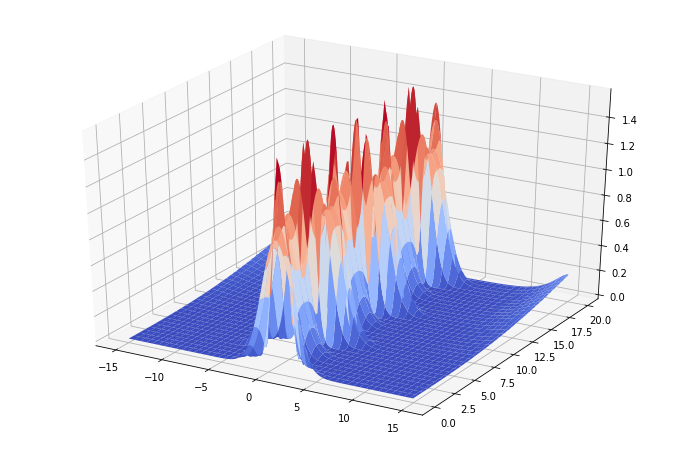

In [143]:
fig = plt.figure(figsize = (12,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,t,abs(u_sol), cmap =  cm.coolwarm)

## Identifiying the principal or most significant modes:

In [144]:
U, S, Vh = scipy.linalg.svd(u_sol)

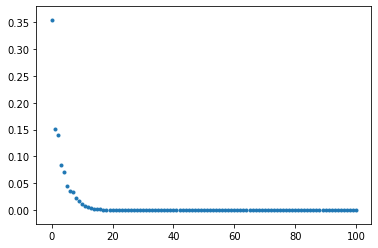

In [145]:
plt.scatter(range(S.size), S/np.sum(S), marker = '.')

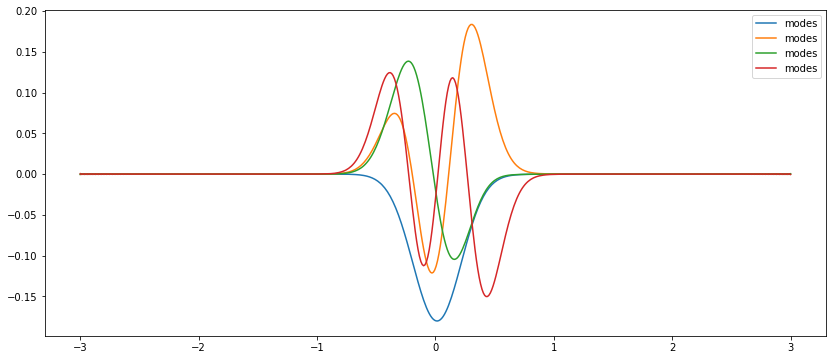

In [146]:
plt.figure(figsize = (14,6))
plt.plot(np.linspace(-3,3,U.shape[0]),(U[:,0:4]).real, label = 'modes')
#plt.plot(np.linspace(-3,3,U.shape[0]),(U[:,1]).real, label = 'mode 2')
#plt.plot(np.linspace(-3,3,U.shape[0]),(U[:,2]).real, label = 'mode 3')
#plt.plot(np.linspace(-3,3,U.shape[0]),(U[:,3]).real, label = 'mode 4')
plt.legend()

## We can take the first 4 modes as the plot above shows these are the most relevant ones.

Now we assume that the solution is of the type 
$$
u(x,t) = \Phi* a(t)
$$
with $a(t) \in \mathbb R^4$ and $\Phi = U[:,0:4]$, i.e 
$$
u(x,t) = a_1(t)\Phi_1 + a_2(t)\Phi_2 + a_3(t)\Phi_3 + a_4(t)\Phi_4
$$

It is like $u$ is in the form of the separated variables, so we can determine the dynamics of the vector $a(t)$ by plugging the expression of $u$ in the equation:

$$
a'(t) = \frac{i}{2}\Phi^{*}\Phi_{xx} @ a(t) - \frac{i}{2}\Phi^{*} @ (x^2.* a(t))
$$
$$
a(0) = a_0 = \Phi^{*}u(x,0)=\Phi^{*}\exp(-\sigma(x-x_0)^2)
$$

where $@$ denotes matrix multiplication and $.*$ denotes component-wise multiplication.

### Implementing the right hand side of the evolution of a:

In [147]:
def a_rhs(t, a, Phi, Lr, V):
    """
    this function computes the r.h.s of the evolution of a as above. 
    parameters: t: time 
    a: vector function a(t)
    Phi: the modes in which we project solution of Schrodinger's eq.
    Lr : Low rank approximation of the linear term Phi^* @ Phi_xx @ a
    """
    rhs = Lr @ a - 0.5j*Phi.conj().T @(V*(Phi@a))
    
    return rhs
    

In [148]:
r = 4
Phi = U[:,0:r]
Phi_xx = np.zeros(Phi.shape, dtype = complex)

# Compute Phixx using the fft: fft(Phi_xx) = (ik)^2.*fft(Phi) then Phi_xx = ifft(-k^2.*fft(Phi))
for j in range(Phi.shape[1]) :
    Phi_xx[:,j] = scipy.fft.ifft((-k**2)*scipy.fft.fft(Phi[:,j]))
a0 = (Phi.conj().T)@u0
t = np.linspace(0, 20, 101) 
Lr = 0.5j*(Phi.conj().T)@Phi_xx


In [149]:
(Phi.conj().T).shape

(4, 512)

In [150]:
Sol_a = scipy.integrate.solve_ivp(a_rhs, (t[0],t[-1]), a0, t_eval = t, args = (Phi,Lr, V))

In [151]:
a_sol = Sol_a.y

In [152]:
print(a_sol.shape, '\n Each row i=0,1,2,3 of a_sol is the component i of the vector funcion a(t) evaluated at each time t' )


(4, 101) 
 Each row i=0,1,2,3 of a_sol is the component i of the vector funcion a(t) evaluated at each time t


In [153]:
u_approx = Phi@a_sol

## Plotting the approximate solution: The solution projected on the first 4 modes.

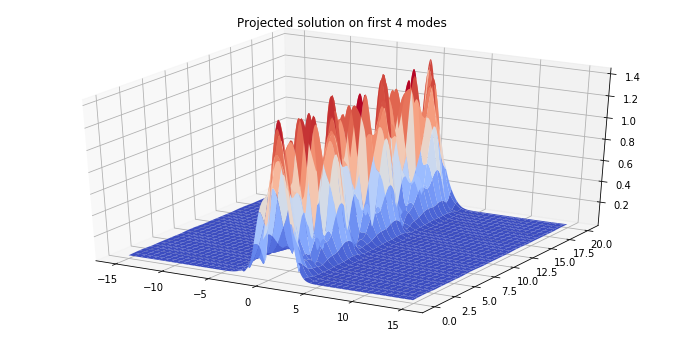

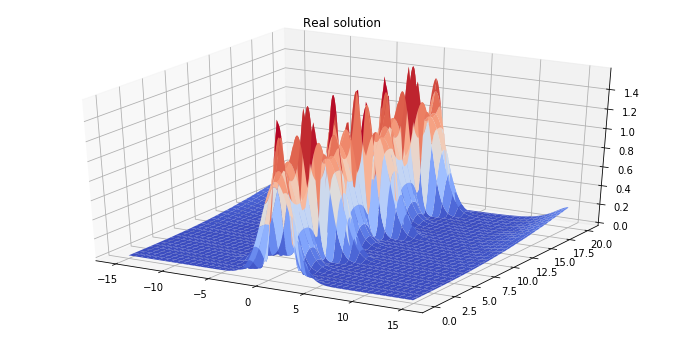

In [154]:
x2 = np.linspace(-L/2, L/2, n+1)  # to generate grid points, assumes first and last are the same..
x = x2[0:n] # grid points
t = np.linspace(0, 20, 101) 

T2, X2 = np.meshgrid(t,x)
fig = plt.figure(figsize = (12,6))
ax2 = fig.gca(projection='3d')
surf2 = ax2.plot_surface(X2,T2,abs(u_approx), cmap =  cm.coolwarm)
plt.title('Projected solution on first 4 modes')

fig = plt.figure(figsize = (12,6))
T1, X1 = np.meshgrid(t,x)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1,T1,abs(u_sol), cmap =  cm.coolwarm)
plt.title('Real solution')
plt.show()

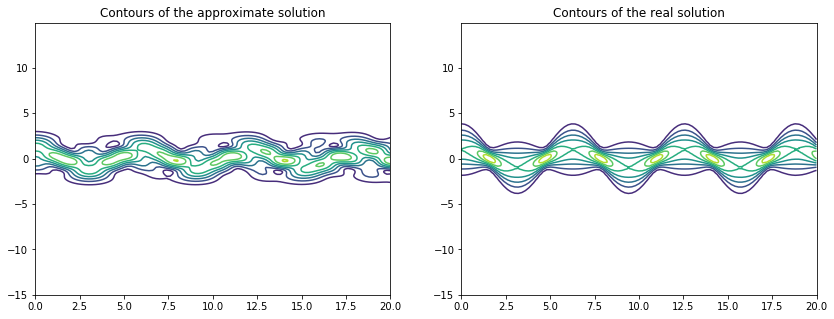

In [155]:
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.contour(T2,X2,abs(u_approx))
plt.title('Contours of the approximate solution')
plt.subplot(122)
plt.contour(T1,X1,abs(u_sol))
plt.title('Contours of the real solution')
plt.show()

#################################################################################################
#################################################################################################
#################################################################################################

# Non Linear Schrodinger's Equation:

$$
  u_t = \frac{i}{2}u_{xx} + i |u|^2u
$$
$$
u(x,0) = u_0(x) = \exp(-\sigma(x-x_0)^2)
$$

$u_0$ is a Gaussian pulse with variance $\sigma$ and centered at $x0$. With boundary conditions: $u\to 0$ as $x \to\pm\infty$

Taking the Fourier transform of the equation w.r.t the spatial variable and solving for $\hat u_t$ we obtain:
$$
\hat u_t =-\frac{ik^2}{2}\hat u +i\hat{|u|^2u}
$$



In [156]:
L = 40
n = 512
x2 = np.linspace(-L//2,L//2,n+1) 
x = x2[0:n] # we consider only the first n points and assume periodicity.
k = 2*np.pi/L * np.hstack((np.array(range(n//2)), np.array(range(-n//2,0)))) # wave numbers for fft
print('columns vectors k and x of shapes: ', k.shape, x.shape)
t = np.linspace(0, 2*np.pi, 101) #time domain collection points.

N = 2 # number of solitons for the initial condition
u0 = N/np.cosh(x) # initial condition
u0t = np.fft.fft(u0) # transformed initial condition

columns vectors k and x of shapes:  (512,) (512,)


In [157]:
print('using the solver scipy.integrate.solve_ivp to find the numerical solution of the ode with r.h.s:')

using the solver scipy.integrate.solve_ivp to find the numerical solution of the ode with r.h.s:


In [158]:
def soliton_rhs(t, u0t, k):
    u0 = scipy.fft.ifft(u0t)
    rhs = -0.5j*(k**2)*u0t + 1j*scipy.fft.fft(((abs(u0))**2)*u0)
    
    return rhs

In [159]:
Sol = scipy.integrate.solve_ivp(soliton_rhs, (t[0],t[-1]), u0t, t_eval = t, args = (k,))

In [160]:
soliton_t = Sol.y

In [161]:
soliton_t.shape  # columns are the solution for each time

(512, 101)

In [162]:
# Transforming back the soliton_t to get the real solution:
soliton = np.zeros(soliton_t.shape, dtype = complex)
for j in range(len(t)):
    soliton[:,j] = scipy.fft.ifft(soliton_t[:,j])

## Plotting the solution obtained:

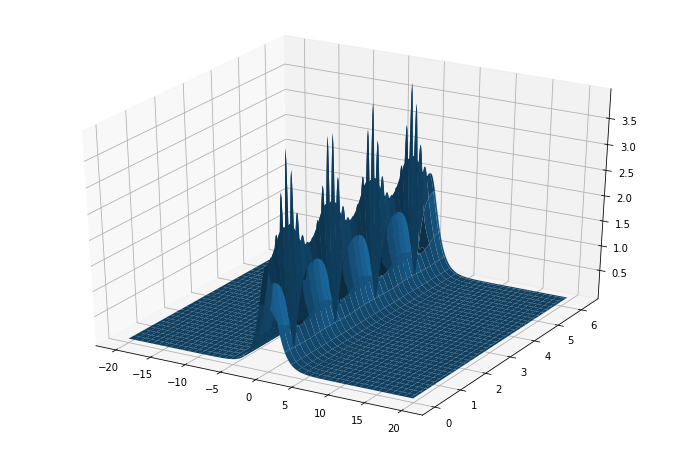

In [163]:
T,X = np.meshgrid(t,x)
fig = plt.figure(figsize = (12,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,T,abs(soliton))

## Identifying the dominant modes to make the POD:
Now let's plot the singular values of the matrix solution soliton to identify the most dominant modes so we can make a low approximation of the solution.

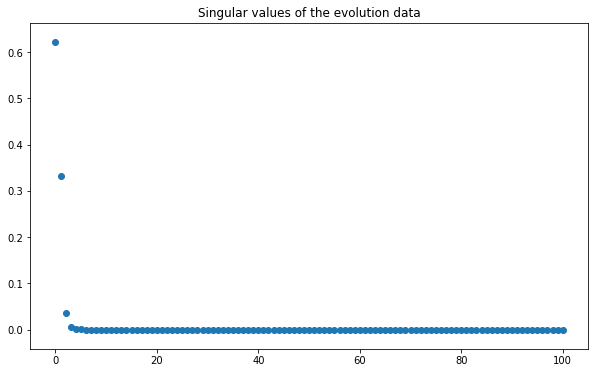

In [164]:
U_soliton, S, _ = scipy.linalg.svd(soliton)
plt.figure(figsize=(10,6))
plt.scatter(range(len(S)), S/np.sum(S), marker = 'o')
plt.title('Singular values of the evolution data')
plt.show()

## According to the plot above we could take rank = 2 or 3 to approximate the solution of the Soliton equation (Non Linear Schrodinger):

Lets assume $u = Phi_r@a(t)$ with $Phi_r$ the matrix the first $r$ columns of $U$ in the svd computed above and $a(t)$ a vector function in $\mathbb R^r$ whose dynamics one can obtained from the soliton equation using the form of the approximated solution.

$$
u_t = \Phi_r @ a'(t) = \frac{i}{2}(\Phi_r)_{xx} @ a(t) + i|\Phi_r @ a(t)|^2\Phi_r @a(t) 
$$

then 
$$
a'(t) = \frac{i}{2}\Phi^{*}_r@(\Phi_r)_{xx}@a(t)+i\Phi_r^{*}@(|\Phi_r @ a(t)|^2\Phi_r @a(t))
$$
$$
a(0) = \Phi_r^{*}u_0
$$
Let's call $L_r = 0.5i\Phi_r^{*}@(\Phi_r)_{xx}$.

In [165]:
r = 2
Phi_r = U_soliton[:,0:r]
Phi_xx = np.zeros(Phi_r.shape,dtype = complex)
for j in range(r):
    Phi_xx[:,j] = -scipy.fft.ifft((k**2)*scipy.fft.fft(Phi_r[:,j]))


a0 = Phi_r.conj().T @ u0
Lr = 0.5j*(Phi_r.conj().T)@Phi_xx

print(a0.shape)

(2,)


In [166]:
# Define the r.h.s of the ode for a'(t):
def a_soliton_rhs(t, a0, Lr, Phi_r):
    rhs = Lr@ a0 +1j*Phi_r.conj().T @((abs(Phi_r@ a0)**2)*(Phi_r @ a0))
    
    return rhs

In [167]:
t = np.linspace(0, 2*np.pi, 101) #time domain collection points.


soliton_approx = scipy.integrate.solve_ivp(a_soliton_rhs, (0,2*np.pi), a0, t_eval = t, args = (Lr,Phi_r) ,
                                          dense_output = True)

In [168]:
a_soliton = soliton_approx.y

In [169]:
print(a_soliton.shape, soliton_approx.t.shape)

(2, 101) (101,)


In [170]:
u_soliton_approx = Phi_r@ a_soliton

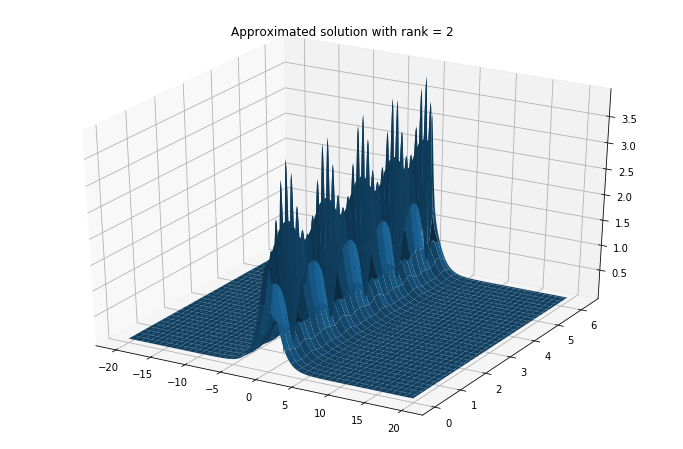

In [171]:
T,X = np.meshgrid(t,x)
fig = plt.figure(figsize = (12,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,T,abs(u_soliton_approx))
plt.title('Approximated solution with rank = ' + str(r))
plt.show()

### contour plots of both the solution and the low rank approximation:

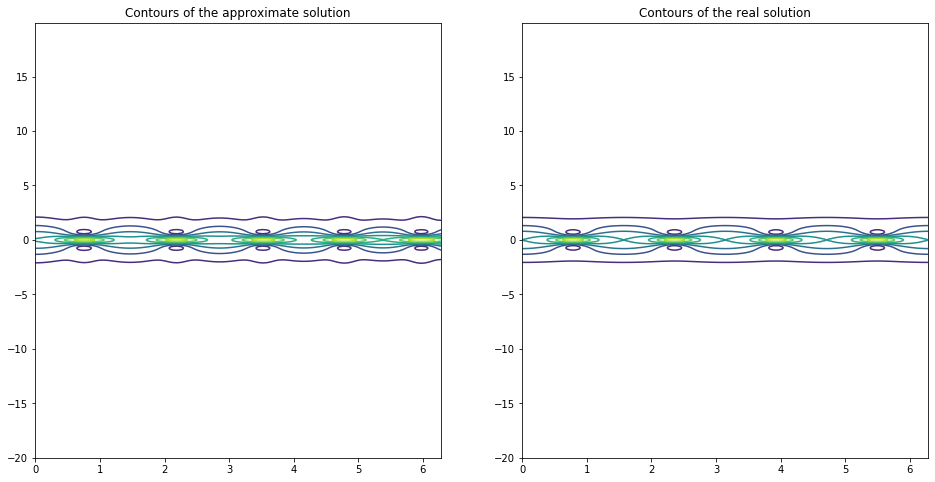

In [172]:
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.contour(T,X,abs(u_soliton_approx))
plt.title('Contours of the approximate solution')
plt.subplot(122)
plt.contour(T,X,abs(soliton))
plt.title('Contours of the real solution')
plt.show()